In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
# from color import color_plot

In [2]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [3]:
pynbody.analysis.halo.center(s.s)

In [4]:
s.properties['boxsize'] = pynbody.units.Unit("1 Gpc")

In [5]:
# pynbody.plot.stars.render(s.s, width='8 kpc')

In [6]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from pynbody.plot.stars import convert_to_mag_arcsec2
from pynbody.derived import lum_den_template
from scipy.ndimage.filters import gaussian_filter

def kpc2pix(qty_kpc, width, resolution):
    kpc_per_pixel = width/resolution
    return int(np.floor(qty_kpc/kpc_per_pixel))

def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

def color_plot(snap, bands=('b','i'), width=10, resolution=500, mag_filter=29, subplot=None,
               center=False, title=None, gaussian_sigma=None, cmap_name='seismic', **kwargs):
    """
    Plot the color as defined by the tuple `bands`

    Parameters
    ----------

    gaussian_sigma: in kpc is the sigma of the gaussian to convolve with the image, to make it more realistic

    mag_filter: all region with magnitude/arcsec^2 higher will be set to NaN
    """
    assert len(bands) == 2

    if subplot:
        fig, ax = subplot.figure, subplot
    else:
        fig, ax = plt.gcf(), plt.gca()

    if center:
        pynbody.analysis.halo.center(snap.s, vel=False);

    # create color
    color_name = '{}-{}'.format(*bands)
    snap.s['{}_mag'.format(color_name)] = snap.s['{}_mag'.format(bands[0])] - snap.s['{}_mag'.format(bands[1])]    
    snap.s['{}_lum_den'.format(color_name)] = lum_den_template(color_name, snap.s)

    # plot color in 10^(-0.4) mag per unit surface
    color_pc2 = pynbody.plot.sph.image(snap.s, qty=color_name + '_lum_den', units='pc^-2',
                                       noplot=True, width=width, log=False, resolution=resolution, **kwargs)

    # convert to mag/arcsec**2
    color_mag_arcsec2 = my_convert_to_mag_arcsec2(color_pc2)

    if gaussian_sigma is not None:
        sigma_pix = kpc2pix(gaussian_sigma, width, resolution)
        color_mag_arcsec2 = gaussian_filter(color_mag_arcsec2, sigma_pix)

    # Filter below a certain magnitude
    if mag_filter is not None:
        color_mag_arcsec2[color_mag_arcsec2 > mag_filter] = np.nan
    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad('black')
    img = ax.imshow(color_mag_arcsec2, cmap=cmap, extent=(-width/2, width/2, -width/2, width/2), origin='lower')
    cbar = ax.figure.colorbar(img);
    ax.set_xlabel('x/kpc')
    ax.set_ylabel('y/kpc')
    cbar.set_label('{} [mag/arcsec$^2$]'.format(color_name.upper()));
    # cont = ax.contour(img, cmap='flag', extent=(-width/2, width/2, -width/2, width/2))
    if title is not None:
        ax.set_title(title)
    plt.draw()
    return color_mag_arcsec2

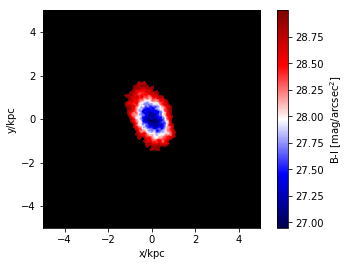

In [7]:
width = 10
fig, ax = plt.subplots(1)
img = color_plot(s, width=width, mag_filter=29, subplot=ax)
# cont = ax.contour(img, cmap='flag', extent=(-width/2, width/2, -width/2, width/2))
# from matplotlib.patches import Ellipse
# ax.add_patch(Ellipse((cx,cy), 200, 300, color='w'))

In [8]:
img[np.isnan(img)] = 0

In [9]:
# from http://breckon.eu/toby/teaching/dip/opencv/SimpleImageAnalysisbyMoments.pdf
def mom2abeps(moments):
    M = moments
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    p = M['mu20'] + M['mu02']
    q = M['mu20'] - M['mu02']
    print(p, q)
    a = np.sqrt(0.5 * p + np.sqrt(4 * M['mu11']**2 - q**2))
    b = np.sqrt(0.5 * p - np.sqrt(4 * M['mu11']**2 - q**2))
    if a < b:
        print('inversion')
        a, b = b, a
    theta = 0.5 * np.arctan(M['mu11']/q)
    eps = (q**2 - 4 * M['mu11']**2) / p**2
    return cx, cy, a, b, theta, eps

In [10]:
import cv2

# ret,thresh = cv2.threshold(img,127,255,0)
# contours, hierarchy = cv2.findContours(thresh, 1, 2)

# cnt = contours[0]
M = cv2.moments(img)
M
# ellipse = cv2.fitEllipse(img)
# ellipse
# cv2.ellipse(img,ellipse,(0,255,0),2)

{'m00': 350363.39121055603,
 'm10': 86121998.94645691,
 'm01': 89690568.91313362,
 'm20': 21441345802.15555,
 'm11': 21911138406.037773,
 'm02': 23487726472.50284,
 'm30': 5404175359223.396,
 'm21': 5422586788752.825,
 'm12': 5703666449474.509,
 'm03': 6282385299064.455,
 'mu20': 271900338.9559694,
 'mu11': -135488825.0645875,
 'mu02': 527570378.0917884,
 'mu30': 58349589.237464875,
 'mu21': 361139561.24080294,
 'mu12': -427828217.0095321,
 'mu03': -416442563.5849337,
 'nu20': 0.0022149927366106282,
 'nu11': -0.0011037380996371895,
 'nu02': 0.004297767924862601,
 'nu30': 8.030470663503562e-07,
 'nu21': 4.970250330593103e-06,
 'nu12': -5.88806534992388e-06,
 'nu03': -5.731368178605406e-06}

In [11]:
cx, cy, a, b, theta, eps = mom2abeps(M)
cx, cy, a, b, theta, eps

799470717.0477579 -255670039.13581902


(245,
 255,
 22125.15375376279,
 17605.3482902246,
 0.24365440926928178,
 -0.01261311855965453)

In [12]:
np.sqrt(a**2-b**2)/a

0.6056693552702623

# Sersic fit

In [13]:
from astropy.modeling import models, fitting
resolution=500
# Fit the data using a box model
y, x = np.mgrid[:resolution, :resolution]

In [14]:
s_init = models.Sersic2D(r_eff=50, n=2, x_0=resolution/2, y_0=resolution/2, ellip=0.7, theta=-np.pi/4,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
fit_s = fitting.SLSQPLSQFitter()
# notnans = np.isfinite(img)
# sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
sersic = fit_s(s_init, x, y, img)
sersic

/home/michele/Software/miniconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:2434: RuntimeWarning: divide by zero encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1011135.6967379379
            Iterations: 31
            Function evaluations: 257
            Gradient evaluations: 31


<Sersic2D(amplitude=28.01252239, r_eff=34.23749365, n=0.07390288, x_0=250., y_0=250., ellip=-0.68580103, theta=0.41214771)>

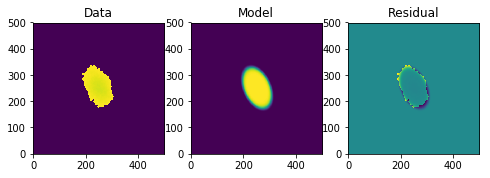

In [15]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
plt.imshow(img, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(sersic(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - sersic(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

## Gaussian fitting

In [16]:
# Fit the data using a Gaussian
g_init = models.Gaussian2D(amplitude=1., x_mean=resolution/2, y_mean=resolution/2, x_stddev=1,
                          bounds={})#'theta':(0, np.pi)})
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y, img)
g

<Gaussian2D(amplitude=39.61032913, x_mean=245.74461146, y_mean=256.12957293, x_stddev=51.55948217, y_stddev=31.06960475, theta=-7.44486235)>

In [17]:
# plt.imshow(np.log(img), origin='lower')
# plt.colorbar()

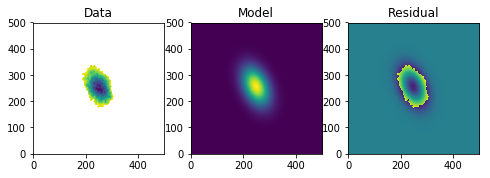

In [18]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
img_orig = img.copy()
img_orig[img_orig==0]=np.nan
plt.imshow(img_orig, origin='lower', interpolation='nearest')
# cmap=plt.get_cmap()
# cmap.set_bad('k')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(g(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - g(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

## Ellipse fitting (no good)

In [19]:
e_init = models.Ellipse2D(amplitude=22, x_0=resolution/2, y_0=resolution/2, a=100, b=50, theta=-np.pi/4,
                          fixed={'amplitude':True, 'x_0':True, 'y_0':True, 'a':True, 'b':True},
                          bounds={'a':(0, 5*resolution), 'b':(0, 5*resolution)})
fit_e = fitting.SLSQPLSQFitter()
e = fit_e(e_init, x, y, img)
e

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3926187.1473448523
            Iterations: 2
            Function evaluations: 16
            Gradient evaluations: 2


<Ellipse2D(amplitude=22., x_0=250., y_0=250., a=100., b=50., theta=-1.21769528e+08)>

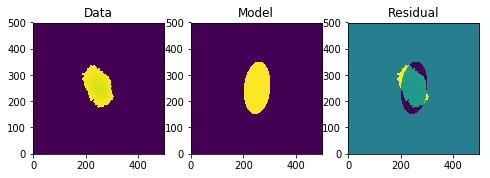

In [20]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
plt.imshow(img, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(e(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - e(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

# Using `photutils`

In [21]:
from photutils import isophote
from photutils import EllipticalAperture
from photutils.isophote import EllipseGeometry, Ellipse

In [22]:
img[np.isnan(img)] = 0

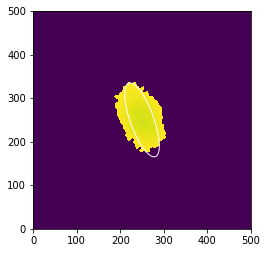

In [23]:
geometry = EllipseGeometry(x0=resolution/2, y0=resolution/2, sma=90, eps=0.7, pa=110.*np.pi/180.)

aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
plt.imshow(img, origin='lower')
aper.plot(color='white')

In [24]:
ellipse = Ellipse(img, geometry)
ellipse

In [25]:
isolist = ellipse.fit_image()

In [26]:
isolist.pa

array([0.        , 1.91986218, 1.91986218, 1.91986218, 1.91986218,
       0.11690603, 0.19304933, 0.34118899, 0.42455883, 0.59513132,
       0.7968954 , 0.83735106, 0.7542522 , 0.45959671, 0.23814584,
       0.10650666, 0.05754109, 3.10993499, 3.08663369, 3.0434993 ,
       3.00397238, 2.9656618 , 2.61996589, 2.1625227 , 2.10989175,
       2.095711  , 2.19254495, 1.91986218, 1.91986218, 1.91986218,
       1.91986218, 1.91986218, 1.91986218, 1.91986218, 1.91986218,
       1.91986218, 1.91986218, 1.91986218, 1.91986218, 1.91986218,
       1.91986218, 1.91986218, 1.91986218, 1.91986218, 1.03995168,
       1.26323492, 1.52545602, 1.66204069, 1.93843492, 2.03955164,
       2.03955164, 2.03955164, 2.02433217, 2.02433217, 1.91986218,
       1.91986218, 1.91986218, 1.91986218])

In [27]:
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,27.250011062732455,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5236456629704638,27.250253001982472,0.002818799395763715,0.3909005162307675,0.018851200681069425,110.0,1.833653350044995,None,13,0,1,5
0.5760102292675102,27.25029544592944,0.0031092704104469424,0.3909005162307675,0.01892149395689725,110.0,1.8398518941651893,None,13,0,1,5
0.6336112521942613,27.250336622311885,0.003432242097396991,0.3909005162307675,0.01904653831540761,110.0,1.8533415630896044,None,13,0,1,5
0.6969723774136874,27.250388966783255,0.003788983470755642,0.3909005162307675,0.037301486963921396,110.0,3.6282951281608846,None,13,0,3,5
0.7666696151550563,27.299904612661503,0.00030122672578712157,0.4443835381695743,0.013026795339191438,6.698221897265513,1.149096474915075,0.3843706416488157,13,0,12,0
0.8433365766705619,27.29694151916248,0.0003605848653261593,0.32088261031053217,0.01205552637220726,11.060911881333894,1.3706694508326625,0.25929062368269234,13,0,13,0
0.9276702343376182,27.29344127710399,0.00046544652618588886,0.21475638431922006,0.014605373607604602,19.548688986352794,2.3347456420648576,0.2804528309154709,13,0,10,0


In [28]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(img.shape, isolist)
residual = img - model_image

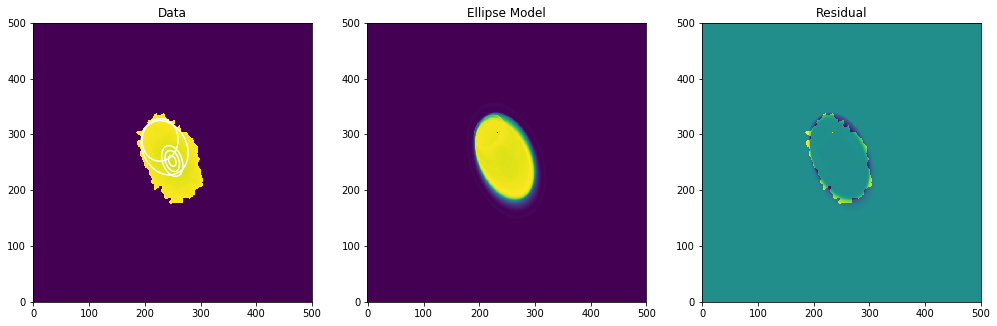

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(img, origin='lower')
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual');

# Density fit

-2.258891428899015

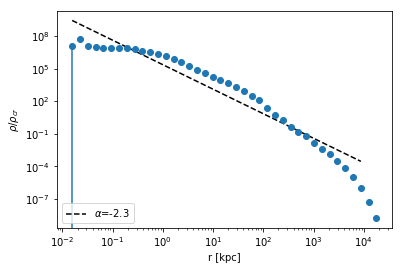

In [30]:
pynbody.plot.density_profile(s, fit=True, fit_factor=0.5)

/home/michele/Software/miniconda3/lib/python3.6/site-packages/pynbody-0.45-py3.6-linux-x86_64.egg/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


('n: ', 1.83577095056151, '  other: ', 21.732331391387113)


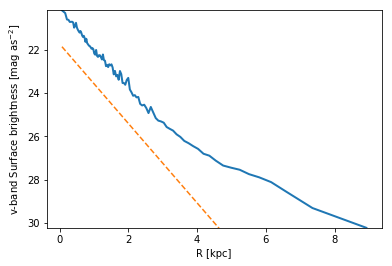

In [31]:
pynbody.plot.stars.sbprofile(s, fit_sersic=True, rmax=10, diskheight=100)